In [1]:
import pandas as pd
import numpy as np
import keras
from keras import models
from keras import layers
from keras import optimizers
import keras_metrics as km
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score,cohen_kappa_score

%matplotlib inline
plt.style.use('seaborn-white')

Using TensorFlow backend.


In [2]:
dataset="bank-additional-full.csv"
bankdata=pd.read_csv(dataset, delimiter=";")
bankdata["response"] = bankdata.y.map({'no':0, 'yes':1})

bankdata.drop(["y"],axis=1, inplace=True)


In [3]:
bankdata.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [4]:
cat_bankdata = bankdata.select_dtypes(include=['object']).copy() #dataframe of columns with object type columns
int_float_bankdata= bankdata.select_dtypes(include=['int64','float64']).copy() #dataframe of columns with int64,float64 type columns
cat_bankdata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 10 columns):
job            41188 non-null object
marital        41188 non-null object
education      41188 non-null object
default        41188 non-null object
housing        41188 non-null object
loan           41188 non-null object
contact        41188 non-null object
month          41188 non-null object
day_of_week    41188 non-null object
poutcome       41188 non-null object
dtypes: object(10)
memory usage: 3.1+ MB


In [5]:
#converting categories into numeric types (numeric encoding)

cat_column=cat_bankdata.columns.tolist()

for i in cat_column:
    cat_bankdata[i] = cat_bankdata[i].astype('category')
    cat_bankdata[i] = cat_bankdata[i].cat.codes
    
cat_bankdata.head()    

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,3,1,0,0,0,0,1,6,1,1
1,7,1,3,1,0,0,1,6,1,1
2,7,1,3,0,2,0,1,6,1,1
3,0,1,1,0,0,0,1,6,1,1
4,7,1,3,0,0,2,1,6,1,1


In [6]:
#creating dummy variables from categorical features (One-Hot encoding)>> this has the benefit of not weighting a value improperly.
#sklearn has "LabelBinarizer" class for one- hot encoding

cat_bankdata_dummy = cat_bankdata.copy()
cat_column_list=cat_bankdata.columns.tolist()

cat_bankdata_dummy = pd.get_dummies(cat_bankdata_dummy, columns=cat_column_list, prefix = cat_column_list, drop_first=True)

In [101]:
print(cat_bankdata.isnull().values.sum()) #checking for the null values

0


In [7]:
#remove constant features from a dataset

from sklearn.feature_selection import VarianceThreshold

#EX/ threshold=0.1 which means that if the variance of the values in a column is less than 0.1, remove those columns.
#In other words, remove feature column where approximately 99% of the values are similar.

variance_filter = VarianceThreshold(threshold=0.1)
variance_filter.fit(int_float_bankdata)  

#Now to get all the features that are NOT CONSTANT, we can use the get_support() method of the filter
print(int_float_bankdata.columns[variance_filter.get_support()])

#Get the number of constant features with the help of the following script:
constant_columns = [column for column in int_float_bankdata.columns  
                    if column not in int_float_bankdata.columns[variance_filter.get_support()]]

int_float_bankdata_filtered=int_float_bankdata[int_float_bankdata.columns[variance_filter.get_support()]]

int_float_bankdata_filtered.head()  #not include "response"

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [8]:
print(constant_columns)

['response']


In [8]:
#Removing Correlated Features
correlated_features = set()   #creating empty set
correlation_matrix = int_float_bankdata.corr()  

for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(correlation_matrix)

int_float_bankdata.drop(columns=list(correlated_features), axis=1, inplace=True)  


                     age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   
response        0.030399  0.405274 -0.066357 -0.324914  0.230181   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968       

In [9]:
resulting_bankdata = pd.concat([cat_bankdata_dummy, int_float_bankdata], axis=1)
resulting_feature_set=resulting_bankdata.drop(["response"],axis=1) #response variable (target variable) excluded
print(resulting_feature_set.head())

   job_1  job_2  job_3  job_4  job_5  job_6  job_7  job_8  job_9  job_10  ...  \
0      0      0      1      0      0      0      0      0      0       0  ...   
1      0      0      0      0      0      0      1      0      0       0  ...   
2      0      0      0      0      0      0      1      0      0       0  ...   
3      0      0      0      0      0      0      0      0      0       0  ...   
4      0      0      0      0      0      0      1      0      0       0  ...   

   poutcome_1  poutcome_2  age  duration  campaign  pdays  previous  \
0           1           0   56       261         1    999         0   
1           1           0   57       149         1    999         0   
2           1           0   37       226         1    999         0   
3           1           0   40       151         1    999         0   
4           1           0   56       307         1    999         0   

   emp.var.rate  cons.price.idx  cons.conf.idx  
0           1.1          93.994      

In [11]:
resulting_bankdata.describe()

,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,...,poutcome_2,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,response
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,0.024619,...,0.033335,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,0.112654
std,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,0.154962,...,0.179512,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,0.316173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,1.000000


In [12]:
resulting_bankdata.shape

(41188, 52)

In [10]:
dict_values=dict(resulting_bankdata["response"].value_counts())
print(dict_values)
print(dict_values[1]/(dict_values[0]+dict_values[1])) #data is imbalanced
#Research on imbalanced classes often considers imbalanced to mean a minority class of 10% to 20%


{0: 36548, 1: 4640}
0.11265417111780131


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(resulting_feature_set, resulting_bankdata["response"], test_size=0.2, random_state=1, stratify=resulting_bankdata["response"])


In [14]:
#Need to standardize, since its not save to feed into a neural network data that takes relatively large values OR
#heterogenous data
#Scale the set of (numeric!!)features.  Perform the scaling operation on the training set ONLY and then continue with the testing set:
#here, I scaled numeric feture set,then concatenate it with previously one-hot-encoded data.(i.e. didn'scaled 0-1 variables)
from sklearn.preprocessing import StandardScaler

X_train_numeric=X_train.iloc[:,43:]
X_test_numeric=X_test.iloc[:,43:]

scaler = StandardScaler()
scaler.fit(X_train_numeric)
X_train_num_scaled = scaler.transform(X_train_numeric)
X_test_num_scaled = scaler.transform(X_test_numeric)

X_train=np.concatenate((X_train_num_scaled,X_train.iloc[:,:43]), axis=1)  #Reassigning X_train variable. Second component is categorical variables
X_test=np.concatenate((X_test_num_scaled,X_test.iloc[:,:43]), axis=1)  #Similar assignment

print(X_train.shape,X_test.shape)

(32950, 51) (8238, 51)


In [15]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(51,)))
model.add(layers.Dense(10, activation='relu'))  #The second layer didn’t receive an input shape argument—instead, it automatically
                                                #inferred its input shape as being the output shape of the layer that came before.
model.add(layers.Dense(1, activation='sigmoid')) 
#sigmoid activation function is to output the probability indicating how likely
#the sample is to have the target 1(in binary classification case)

model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True),  #loss and optimer must be defined before feeding data into a network
              loss='binary_crossentropy',             #"rmsprop" optimizer is generally a good choice, whatever the problem
              metrics=[km.binary_precision(), km.binary_recall()])

tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn


In [16]:
x_val = X_train[:3000]
X_train = X_train[3000:]
y_val = y_train[:3000]
y_train = y_train[3000:]

In [18]:
history = model.fit(X_train,y_train, epochs=10,batch_size=128, validation_data=(x_val, y_val))

#Note that the call to model.fit() returns a History object. This object has a member
#history, which is a dictionary containing data about everything that happened
#during training.

Train on 29950 samples, validate on 3000 samples
Epoch 1/10
29950/29950 [==============================] - 2s 68us/step - loss: 0.2627 - precision: 0.1985 - recall: 0.0018 - val_loss: 0.2192 - val_precision: 0.5929 - val_recall: 0.0170
Epoch 2/10
29950/29950 [==============================] - 1s 45us/step - loss: 0.2041 - precision: 0.6455 - recall: 0.2137 - val_loss: 0.2049 - val_precision: 0.5532 - val_recall: 0.5130
Epoch 3/10
29950/29950 [==============================] - 1s 44us/step - loss: 0.1950 - precision: 0.5840 - recall: 0.5445 - val_loss: 0.2006 - val_precision: 0.5624 - val_recall: 0.5378
Epoch 4/10
29950/29950 [==============================] - 1s 44us/step - loss: 0.1907 - precision: 0.5972 - recall: 0.5827 - val_loss: 0.1991 - val_precision: 0.5702 - val_recall: 0.5445
Epoch 5/10
29950/29950 [==============================] - 1s 48us/step - loss: 0.1885 - precision: 0.6124 - recall: 0.5762 - val_loss: 0.1979 - val_precision: 0.5861 - val_recall: 0.5282
Epoch 6/10
29950

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_precision', 'val_recall', 'loss', 'precision', 'recall'])

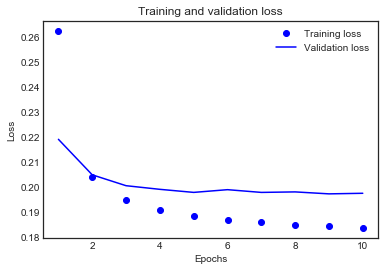

In [20]:
#import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict["recall"]) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

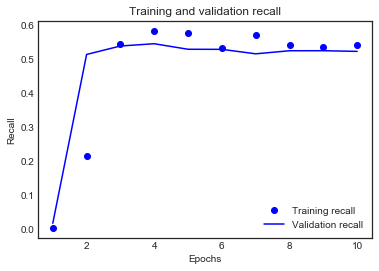

In [21]:
acc_values = history_dict['recall']
val_acc_values = history_dict['val_recall']
plt.plot(epochs, acc_values, 'bo', label='Training recall')
plt.plot(epochs, val_acc_values, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [22]:
results = model.evaluate(X_test, y_test)
print(results) 

#output returns[loss,accuracy]

8238/8238 [==============================] - 1s 78us/step
[0.18927207459456194, 0.6110388040542603, 0.5423803329467773]


In [26]:
y_pred = model.predict_classes(X_test)
#https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/


In [28]:
confusion_matrix(y_pred,y_test)

array([[7011,  417],
       [ 299,  511]], dtype=int64)

In [47]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

def NN_model():
# create model
    model = models.Sequential()
    model.add(layers.Dense(12, input_shape=(51,), activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model


model = KerasClassifier(build_fn=NN_model, epochs=10, batch_size=256, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())


0.9106508493423462


In [48]:
from sklearn.model_selection import GridSearchCV

def NN_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = models.Sequential()
    model.add(layers.Dense(12, input_shape=(51,), kernel_initializer=init, activation='relu'))
    model.add(layers.Dense(10, kernel_initializer=init, activation='relu'))
    model.add(layers.Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=NN_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
epochs = [4, 8, 12]
batches = [64,128, 256]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

C:\Anaconda_last\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda_last\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [49]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.912688 using {'batch_size': 128, 'epochs': 8, 'optimizer': 'Nadam'}
0.898331 (0.006773) with: {'batch_size': 64, 'epochs': 4, 'optimizer': 'SGD'}
0.909316 (0.002162) with: {'batch_size': 64, 'epochs': 4, 'optimizer': 'RMSprop'}
0.908982 (0.000961) with: {'batch_size': 64, 'epochs': 4, 'optimizer': 'Adagrad'}
0.909149 (0.002524) with: {'batch_size': 64, 'epochs': 4, 'optimizer': 'Adadelta'}
0.910651 (0.002284) with: {'batch_size': 64, 'epochs': 4, 'optimizer': 'Adam'}
0.909249 (0.001430) with: {'batch_size': 64, 'epochs': 4, 'optimizer': 'Adamax'}
0.910250 (0.001775) with: {'batch_size': 64, 'epochs': 4, 'optimizer': 'Nadam'}
0.906010 (0.003790) with: {'batch_size': 64, 'epochs': 8, 'optimizer': 'SGD'}
0.909115 (0.002057) with: {'batch_size': 64, 'epochs': 8, 'optimizer': 'RMSprop'}
0.909850 (0.002209) with: {'batch_size': 64, 'epochs': 8, 'optimizer': 'Adagrad'}
0.910751 (0.001262) with: {'batch_size': 64, 'epochs': 8, 'optimizer': 'Adadelta'}
0.910551 (0.001458) with: {'batch_